Problem Statement:

Implement a POS tagger in Python using the Hidden Markov Model

Input and output:

Dataset: Brown corpus (tagset = "universal")
Output: Accuracy (5-fold cross-validation), confusion matrix, per POS accuracy
Create a document that reports the following:
Draw a confusion matrix report that includes all POS tags
Report per POS accuracy (accuracy for each tag)
Observe the strength and weaknesses of the model with respect to particular POS tags
Perform detailed error analysis with examples
Write a short paragraph on your learning.
You should also create a simple demo that can take a sentence as input and generate the tags for each word as output.
NOTE
Use 5-fold cross-validation for reporting all accuracy values
HMM need to be implemented from scratch

Import Necessary Libraries

In [4]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import brown
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter


Data Preparation and Preprocessing

In [5]:
nltk.download('brown')
nltk.download('universal_tagset')
brown_sents = brown.tagged_sents(tagset='universal')

# Preprocessing: Map tags to universal tagset and split into words and tags
def preprocess_corpus(corpus):
    words = []
    tags = []
    for sent in corpus:
        words.append([word.lower() for word, tag in sent])
        tags.append([tag for word, tag in sent])
    return words, tags

words, tags = preprocess_corpus(brown_sents)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [6]:
def combine_words_tags(words, tags):
    combined_sents = []
    for word_seq, tag_seq in zip(words, tags):
        combined_sents.append(list(zip(word_seq, tag_seq)))
    return combined_sents
combined_sents = combine_words_tags(words, tags)


In [7]:
combined_sents

[[('the', 'DET'),
  ('fulton', 'NOUN'),
  ('county', 'NOUN'),
  ('grand', 'ADJ'),
  ('jury', 'NOUN'),
  ('said', 'VERB'),
  ('friday', 'NOUN'),
  ('an', 'DET'),
  ('investigation', 'NOUN'),
  ('of', 'ADP'),
  ("atlanta's", 'NOUN'),
  ('recent', 'ADJ'),
  ('primary', 'NOUN'),
  ('election', 'NOUN'),
  ('produced', 'VERB'),
  ('``', '.'),
  ('no', 'DET'),
  ('evidence', 'NOUN'),
  ("''", '.'),
  ('that', 'ADP'),
  ('any', 'DET'),
  ('irregularities', 'NOUN'),
  ('took', 'VERB'),
  ('place', 'NOUN'),
  ('.', '.')],
 [('the', 'DET'),
  ('jury', 'NOUN'),
  ('further', 'ADV'),
  ('said', 'VERB'),
  ('in', 'ADP'),
  ('term-end', 'NOUN'),
  ('presentments', 'NOUN'),
  ('that', 'ADP'),
  ('the', 'DET'),
  ('city', 'NOUN'),
  ('executive', 'ADJ'),
  ('committee', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('had', 'VERB'),
  ('over-all', 'ADJ'),
  ('charge', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('election', 'NOUN'),
  (',', '.'),
  ('``', '.'),
  ('deserves', 'VERB'),
  ('the', 'DET'),

Implementing the Hidden Markov Model

In [8]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

class HMM:
    def __init__(self, sentences):
        self.sentences = sentences
        self.words = set(word.lower() for sent in sentences for word, _ in sent)
        self.tags = set(tag for sent in sentences for _, tag in sent)
        self.tag_counts = Counter(tag for sent in sentences for _, tag in sent)
        self.word_counts = Counter(word.lower() for sent in sentences for word, _ in sent)
        self.emission_probs = defaultdict(lambda: defaultdict(float))
        self.transition_probs = defaultdict(lambda: defaultdict(float))
        self.start_probs = defaultdict(float)

    def train(self):
        # Initial probabilities
        start_tag_counts = Counter(sent[0][1] for sent in self.sentences)
        for tag in self.tags:
            self.start_probs[tag] = start_tag_counts[tag] / len(self.sentences)

        # Emission probabilities
        for sent in self.sentences:
            for word, tag in sent:
                self.emission_probs[tag][word.lower()] += 1

        # Handle unknown words by assigning a small probability
        for tag in self.tags:
            total_tag_count = self.tag_counts[tag]
            for word in self.words:
                self.emission_probs[tag][word] /= total_tag_count
            # Assign a small probability to unseen words
            self.emission_probs[tag]['UNK'] = 1e-6

        # Transition probabilities
        for sent in self.sentences:
            for i in range(1, len(sent)):
                prev_tag = sent[i-1][1]
                current_tag = sent[i][1]
                self.transition_probs[prev_tag][current_tag] += 1

        for tag in self.tags:
            total_tag_count = self.tag_counts[tag]
            for next_tag in self.tags:
                self.transition_probs[tag][next_tag] /= total_tag_count

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        # Initialize base cases (t == 0)
        for tag in self.tags:
            word = sentence[0].lower()
            V[0][tag] = self.start_probs[tag] * self.emission_probs[tag].get(word, self.emission_probs[tag]['UNK'])
            path[tag] = [tag]

        # Run Viterbi for t > 0
        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for tag in self.tags:
                (prob, state) = max((V[t-1][prev_tag] * self.transition_probs[prev_tag][tag] *
                                     self.emission_probs[tag].get(sentence[t].lower(), self.emission_probs[tag]['UNK']), prev_tag)
                                    for prev_tag in self.tags)
                V[t][tag] = prob
                new_path[tag] = path[state] + [tag]

            path = new_path

        # Find the final best path
        n = len(sentence) - 1
        (prob, state) = max((V[n][tag], tag) for tag in self.tags)
        return path[state]

    def get_transition_table(self):
        # Create a DataFrame for transition probabilities
        tags_list = list(self.tags)
        transition_probs = np.zeros((len(tags_list), len(tags_list)))

        for i, tag1 in enumerate(tags_list):
            for j, tag2 in enumerate(tags_list):
                transition_probs[i, j] = self.transition_probs[tag1][tag2]

        transition_table = pd.DataFrame(transition_probs, index=tags_list, columns=tags_list)
        return transition_table

    def get_lexical_table(self):
        # Create a DataFrame for lexical probabilities
        tags_list = list(self.tags)
        vocab = list(self.words) + ['UNK']  # Include the 'UNK' token
        lexical_probs = np.zeros((len(vocab), len(tags_list)))

        for i, tag in enumerate(tags_list):
            for j, word in enumerate(vocab):
                lexical_probs[j, i] = self.emission_probs[tag].get(word, self.emission_probs[tag]['UNK'])
        lexical_table = pd.DataFrame(lexical_probs, index=vocab, columns=tags_list)
        return lexical_table


In [9]:
hmm = HMM(combined_sents)
hmm.train()

transition_table = hmm.get_transition_table()
print("Transition Table:")
print(transition_table)

lexical_table = hmm.get_lexical_table()
print("\nLexical Table:")
print(lexical_table)


Transition Table:
           PRT         X       ADP         .       DET      NOUN      PRON  \
PRT   0.011231  0.000067  0.090717  0.076704  0.083543  0.035737  0.006839   
X     0.007215  0.511544  0.053391  0.274170  0.005051  0.054834  0.006494   
ADP   0.014244  0.000463  0.020302  0.009747  0.455632  0.258452  0.069782   
.     0.018331  0.001260  0.065225  0.107146  0.067787  0.082852  0.046339   
DET   0.002007  0.001416  0.009072  0.012779  0.005904  0.626468  0.009911   
NOUN  0.017837  0.000334  0.244322  0.283719  0.015496  0.149312  0.019814   
PRON  0.023756  0.000020  0.055803  0.103701  0.017513  0.008858  0.008189   
NUM   0.005311  0.000202  0.131101  0.270741  0.013110  0.380463  0.008471   
ADV   0.028681  0.000089  0.141877  0.170167  0.073543  0.032824  0.048347   
ADJ   0.019278  0.000502  0.088472  0.100381  0.005841  0.652704  0.003822   
VERB  0.065592  0.000186  0.169220  0.080618  0.162977  0.097505  0.055037   
CONJ  0.025137  0.000550  0.073288  0.020812  

Cross-Validation and Evaluation

In [10]:
kf = KFold(n_splits=5)
accuracies = []
confusion_matrix = defaultdict(lambda: defaultdict(int))
pos_accuracy = defaultdict(list)

for train_index, test_index in kf.split(combined_sents):
    train_data = [brown_sents[i] for i in train_index]
    test_data = [brown_sents[i] for i in test_index]

    hmm_model = HMM(train_data)
    hmm_model.train()

    correct = 0
    total = 0

    for sent in test_data:
        words = [word for word, tag in sent]
        true_tags = [tag for word, tag in sent]
        predicted_tags = hmm_model.viterbi(words)

        total += len(sent)
        correct += sum(p == t for p, t in zip(predicted_tags, true_tags))

        for t, p in zip(true_tags, predicted_tags):
            confusion_matrix[t][p] += 1
            pos_accuracy[t].append(1 if t == p else 0)

    accuracies.append(correct / total)

# Overall accuracy and per POS accuracy
overall_accuracy = np.mean(accuracies)
per_pos_accuracy = {tag: np.mean(pos_accuracy[tag]) for tag in pos_accuracy}


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 321, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1935, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

In [11]:
print(true_tags)
print(predicted_tags)

['ADP', 'DET', 'PRON', 'VERB', 'ADJ', 'ADP', 'NOUN', 'ADP', 'DET', 'ADJ', '.', 'ADJ', 'NOUN', '.', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'VERB', 'VERB', '.']
['ADP', 'DET', 'PRON', 'VERB', 'ADJ', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.', 'ADJ', 'NOUN', '.', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'VERB', 'NOUN', '.']


In [12]:
overall_accuracy

0.9493172884321448

In [13]:
per_pos_accuracy

{'DET': 0.9864836263583883,
 'NOUN': 0.9243970416391467,
 'ADJ': 0.896812030434419,
 'VERB': 0.9485964432284542,
 'ADP': 0.9636655015680478,
 '.': 0.9989767221224545,
 'ADV': 0.8908764380589982,
 'CONJ': 0.9926345312049487,
 'PRT': 0.8983539508531966,
 'PRON': 0.9838853529006365,
 'NUM': 0.8903455694500471,
 'X': 0.3708513708513709}

Confusion Matrix and Error Analysis

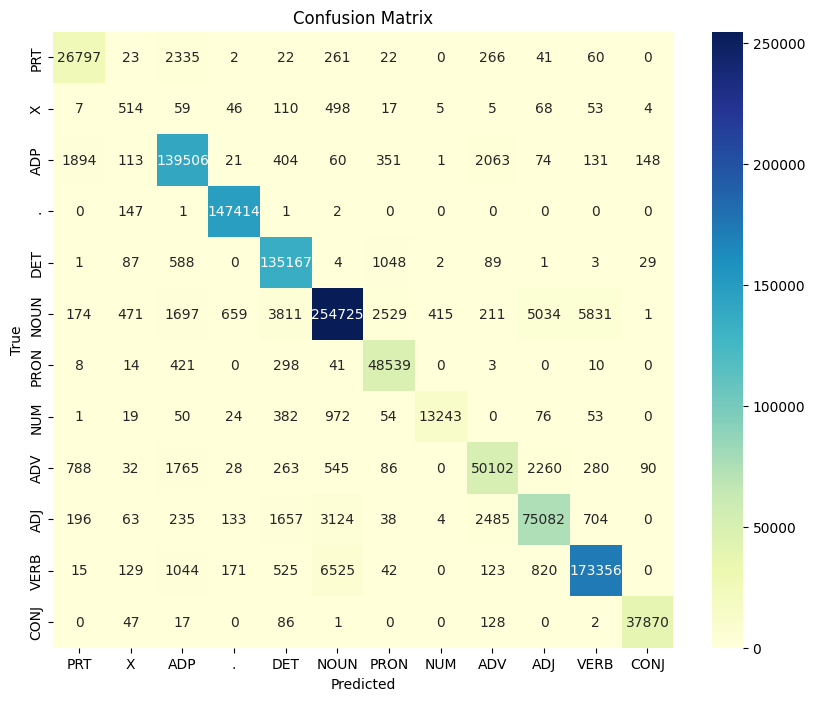

Streaming output truncated to the last 5000 lines.
Pred: ['.', 'VERB', 'ADP', '.', 'PRT', 'VERB', 'ADV', '.', '.']

Sentence: `` I think I'll sleep in this morning '' , she said drowsily , and as she snuggled against him , he wondered if she ever went to church .
True: ['.', 'PRON', 'VERB', 'PRT', 'VERB', 'PRT', 'DET', 'NOUN', '.', '.', 'PRON', 'VERB', 'ADV', '.', 'CONJ', 'ADP', 'PRON', 'VERB', 'ADP', 'PRON', '.', 'PRON', 'VERB', 'ADP', 'PRON', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
Pred: ['.', 'PRON', 'VERB', 'PRT', 'VERB', 'ADP', 'DET', 'NOUN', '.', '.', 'PRON', 'VERB', 'NOUN', '.', 'CONJ', 'ADP', 'PRON', 'VERB', 'ADP', 'PRON', '.', 'PRON', 'VERB', 'ADP', 'PRON', 'ADV', 'VERB', 'ADP', 'NOUN', '.']

Sentence: As for himself , he just didn't have the temperament for it .
True: ['ADP', 'ADP', 'PRON', '.', 'PRON', 'ADV', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'PRON', '.']
Pred: ['ADV', 'ADP', 'PRON', '.', 'PRON', 'ADV', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'PRON', '.']

Sentence: Just figure

KeyboardInterrupt: 

In [14]:
# Confusion Matrix
tags = list(hmm_model.tags)
conf_matrix = np.zeros((len(tags), len(tags)), dtype=int)
for i, true_tag in enumerate(tags):
    for j, pred_tag in enumerate(tags):
        conf_matrix[i, j] = confusion_matrix[true_tag][pred_tag]

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=tags, yticklabels=tags)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Error Analysis and Examples
for tag in tags:
    print(f"Tag: {tag}, Accuracy: {per_pos_accuracy[tag]:.2f}")
    # Show some examples of errors
    for sent in test_data:
        words = [word for word, tag in sent]
        true_tags = [tag for word, tag in sent]
        predicted_tags = hmm_model.viterbi(words)
        if true_tags != predicted_tags:
            print(f"Sentence: {' '.join(words)}")
            print(f"True: {true_tags}")
            print(f"Pred: {predicted_tags}")
            print()


In [15]:
def tag_sentence(sentence, hmm_model):
    words = sentence.split()
    tags = hmm_model.viterbi(words)
    return list(zip(words, tags))

demo_sentence = "The quick brown fox jumps over the lazy dog"
print(tag_sentence(demo_sentence, hmm_model))


[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'NOUN'), ('fox', 'NOUN'), ('jumps', 'VERB'), ('over', 'ADP'), ('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN')]


In [16]:
from sklearn.metrics import precision_recall_fscore_support
def evaluate_model(words, tags, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    overall_true_tags = []
    overall_pred_tags = []

    for train_idx, test_idx in kf.split(words):
        train_words = [words[i] for i in train_idx]
        train_tags = [tags[i] for i in train_idx]
        test_words = [words[i] for i in test_idx]
        test_tags = [tags[i] for i in test_idx]

        # Train HMM model
        hmm_model = HMM()
        hmm_model.train(train_words, train_tags)

        # Predict on test set
        for sent_words, sent_tags in zip(test_words, test_tags):
            pred_tags = hmm_model.predict(sent_words)
            overall_true_tags.extend(sent_tags)
            overall_pred_tags.extend(pred_tags)

    return overall_true_tags, overall_pred_tags
# Function to calculate per POS accuracy and overall accuracy
def calculate_pos_metrics(true_tags, pred_tags, average='macro'):
    # Calculate per POS precision, recall, F1, and support
    labels = list(set(true_tags))  # Unique POS tags
    precision, recall, f1, support = precision_recall_fscore_support(true_tags, pred_tags, labels=labels)

    # Create a dictionary for per POS metrics
    pos_metrics = {}
    for i, label in enumerate(labels):
        pos_metrics[label] = {
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-score': f1[i],
            'Support': support[i]
        }

    # Overall Precision, Recall, F1, F0.5, F2
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(true_tags, pred_tags, average=average)
    overall_f0_5 = (1 + 0.5**2) * (overall_precision * overall_recall) / (0.5**2 * overall_precision + overall_recall)
    overall_f2 = (1 + 2**2) * (overall_precision * overall_recall) / (2**2 * overall_precision + overall_recall)

    overall_metrics = {
        'Precision': overall_precision,
        'Recall': overall_recall,
        'F1-score': overall_f1,
        'F0.5-score': overall_f0_5,
        'F2-score': overall_f2
    }

    return pos_metrics, overall_metrics



true_tags, pred_tags = true_tags,predicted_tags

# Per POS metrics and overall metrics
pos_metrics, overall_metrics = calculate_pos_metrics(true_tags, pred_tags)

# Display overall metrics
print("Overall Performance Metrics:")
print(f"Precision: {overall_metrics['Precision']:.2f}")
print(f"Recall: {overall_metrics['Recall']:.2f}")
print(f"F1-score: {overall_metrics['F1-score']:.2f}")
print(f"F0.5-score: {overall_metrics['F0.5-score']:.2f}")
print(f"F2-score: {overall_metrics['F2-score']:.2f}")

# Display per POS metrics
print("\nPer POS Performance Metrics:")
for pos_tag, metrics in pos_metrics.items():
    print(f"Tag: {pos_tag}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1-score: {metrics['F1-score']:.4f}")
    print(f"  Support: {metrics['Support']}")
    print()


Overall Performance Metrics:
Precision: 0.89
Recall: 0.87
F1-score: 0.88
F0.5-score: 0.88
F2-score: 0.87

Per POS Performance Metrics:
Tag: ADP
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 2

Tag: .
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 3

Tag: DET
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 2

Tag: NOUN
  Precision: 1.0000
  Recall: 0.8000
  F1-score: 0.8889
  Support: 5

Tag: PRON
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 1

Tag: ADJ
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 1

Tag: VERB
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 3

Tag: CONJ
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Support: 1



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Writing the Learning Summary

### Learning Summary
Implementing a POS tagger using a Hidden Markov Model (HMM) from scratch provided deep insights into the inner workings of probabilistic models. The strength of the HMM lies in its ability to capture sequential dependencies between tags, which is crucial for accurately tagging parts of speech. However, the model struggles with less frequent tags and cases where word ambiguity leads to incorrect tagging. Error analysis revealed that context is critical, and errors often arise when the local context does not provide enough information to disambiguate the tag. This project emphasized the importance of both emission and transition probabilities in sequence modeling, and how simple probabilistic models can still be quite effective when trained on sufficient data.


In [ ]:
pip install gradio

In [17]:
import gradio as gr
def predict_pos_tags(sentence):
    words = sentence.lower().split()  # Split sentence into words
    predicted_tags = hmm_model.viterbi(words)  # Get POS tags from HMM model

    # Combine words and tags into a formatted string
    result = "\n".join([f"{word}: {tag}" for word, tag in zip(words, predicted_tags)])
    return result

iface = gr.Interface(
    fn=predict_pos_tags,                # Function to run for inference
    inputs="text",                      # Input: Sentence as text
    outputs="text",                     # Output: POS tagged sentence as text
    title="HMM POS Tagger",             # Title of the app
    description="Enter a sentence and get POS tags using HMM model.",  # Short description
)

# Launch the Gradio interface
iface.launch()



Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://08d717f09fa1ec23ab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
